# 0) Modules & Functions

In [ ]:
import os
import pandas as pd
from rdkit import Chem
import subprocess
import hashlib
import tempfile
import base64
import numpy as np
from itertools import combinations
from scipy.stats import pearsonr
from tqdm import tqdm
import time
from collections import defaultdict
from rdkit.Chem import AllChem
from rdkit import RDLogger
import warnings
import re
from rdkit.Chem import inchi
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from rdkit.Chem import Descriptors
from rdkit import Chem
from rdkit.Chem import Draw

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

warnings.filterwarnings("ignore", category=UserWarning, module="rdkit")
warnings.filterwarnings("ignore", category=FutureWarning, module="rdkit")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="rdkit")


from itertools import combinations
from pathlib import Path


import os
import pandas as pd
from pathlib import Path


import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, matthews_corrcoef,
    balanced_accuracy_score, f1_score, roc_curve
)
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

# === Fingerprint computation ===
def smiles_to_morgan(smiles, radius=3, n_bits=4096):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits))

def parallel_fingerprint(smiles_list, n_jobs=-1):
    return Parallel(n_jobs=n_jobs)(delayed(smiles_to_morgan)(s) for s in smiles_list)

# === Main CV loop ===
def run_repeated_cv_fingerprint_classification(df, model_type='rf', n_splits=10, n_repeats=3, random_state=42):
    df = df[['SMILES', 'AUG']].dropna().drop_duplicates("SMILES")
    df['AUG'] = df['AUG'].astype(bool)

    print("🧠 Parallel fingerprinting...")
    fps = parallel_fingerprint(df["SMILES"].tolist())
    X = np.stack(fps)
    y = df["AUG"].astype(int).values

    print("🔁 Repeated Stratified CV...")

    metrics_per_repeat = []
    all_true, all_prob = [], []

    for repeat in range(n_repeats):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state + repeat)
        y_true_repeat, y_pred_repeat, y_prob_repeat = [], [], []

        if model_type == 'rf':
            model_factory = lambda: RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=repeat)
        elif model_type == 'xgb':
            pos_weight = (y == 0).sum() / max((y == 1).sum(), 1)
            model_factory = lambda: XGBClassifier(n_estimators=100, scale_pos_weight=pos_weight, use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=repeat)
        else:
            raise ValueError("Model must be 'rf' or 'xgb'")

        for train_idx, test_idx in skf.split(X, y):
            model = model_factory()
            model.fit(X[train_idx], y[train_idx])
            y_pred = model.predict(X[test_idx])
            y_prob = model.predict_proba(X[test_idx])[:, 1]

            y_true_repeat.extend(y[test_idx])
            y_pred_repeat.extend(y_pred)
            y_prob_repeat.extend(y_prob)

        # Store metrics for the repeat
        y_prob = [1 if i >0.5 else 0 for i in y_prob]
        y_pred = [1 if i >0.5 else 0 for i in y_pred]
        metrics_per_repeat.append({
            "ROC_AUC": roc_auc_score(y_true_repeat, y_prob_repeat),
            "MCC": matthews_corrcoef(y_true_repeat, y_pred_repeat),
            "Balanced Accuracy": balanced_accuracy_score(y_true_repeat, y_pred_repeat),
            "F1 Score": f1_score(y_true_repeat, y_pred_repeat),
            "Model": model_type.upper()
        })

        all_true.extend(y_true_repeat)
        all_prob.extend(y_prob_repeat)

    return pd.DataFrame(metrics_per_repeat), np.array(all_true), np.array(all_prob), model_type.upper()

# === Plotting ===
def plot_box_and_roc(df_metrics, y_true, y_prob, model_label):
    melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")

    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=melted, x="Metric", y="Score", hue="Model")
    plt.ylim(0, 1)
    plt.title(f"{model_label} Metrics (3x5 Repeated CV)")
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'{model_label} (AUC = {roc_auc_score(y_true, y_prob):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 1) Prepare the data

In [64]:
set_augmentation = "AC"

full_MTL = pd.read_parquet(f"../data/aug/{set_augmentation}/MTL/MTL_merged.parquet")
full_MTL.AUG.value_counts()

AUG
True     12926
False     9645
Name: count, dtype: int64

In [68]:
df_metrics, y_true, y_prob, label = run_repeated_cv_fingerprint_classification(full_MTL, model_type='rf')

🧠 Parallel fingerprinting...


[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerator
[19:28:32] DEPRECATION WARNING: please use MorganGenerat

🔁 Repeated Stratified CV...


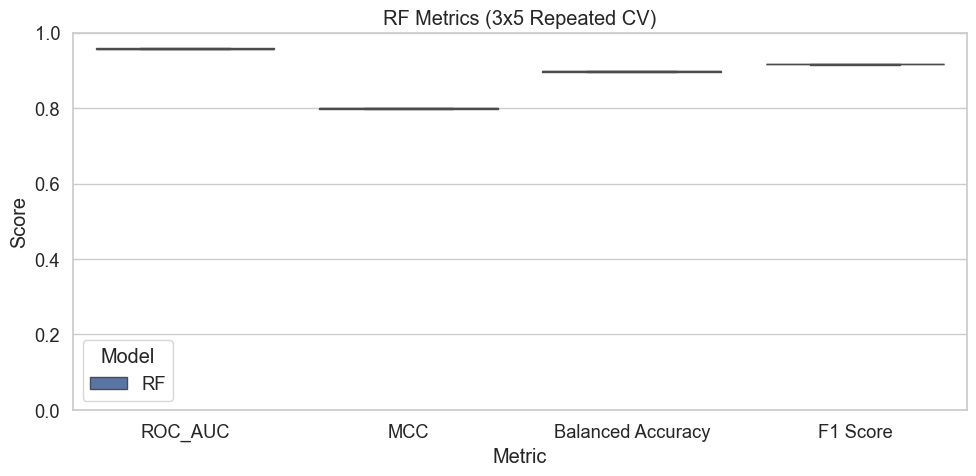

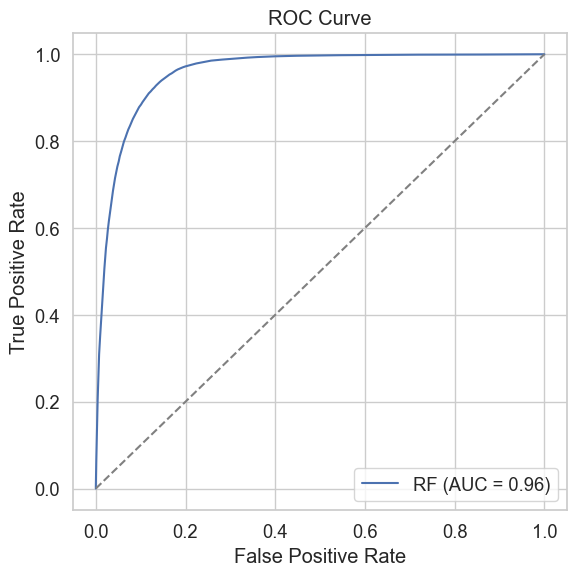

In [69]:
plot_box_and_roc(df_metrics, y_true, y_prob, label)

In [70]:
full_MTL.AUG.value_counts()


AUG
True     12926
False     9645
Name: count, dtype: int64

[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerator
[19:29:26] DEPRECATION WARNING: please use MorganGenerat

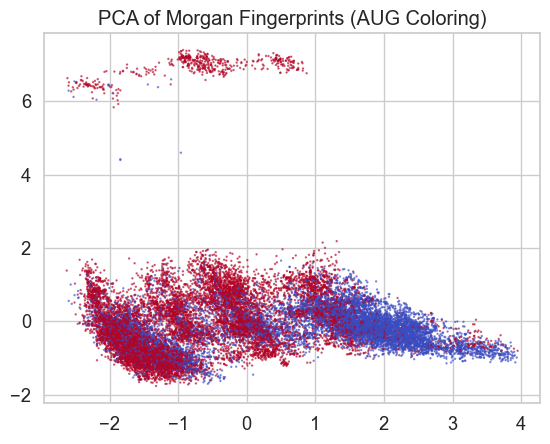

In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_fp = np.stack(parallel_fingerprint(full_MTL["SMILES"].tolist()))
y = full_MTL["AUG"].astype(int).values

pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_fp)

plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y, cmap="coolwarm", alpha=0.6, s = .5)
plt.title("PCA of Morgan Fingerprints (AUG Coloring)")
plt.show()

In [72]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scores = []
for train_idx, test_idx in cv.split(X_fp, y):
    dummy.fit(X_fp[train_idx], y[train_idx])
    y_pred = dummy.predict(X_fp[test_idx])
    ba = balanced_accuracy_score(y[test_idx], y_pred)
    scores.append(ba)

print("Dummy classifier BA scores:", scores)

Dummy classifier BA scores: [0.5, 0.5, 0.5]
